# Visualizing Loan Amount Predictions via PDP and ICE

#### Trustworthy AI Examples Series

This notebook demonstrates how global model summaries can mask individual variation in loan amount predictions. Using the German Credit Data dataset, this example scenario simulates a loan-sizing pipeline that predicts credit amount based on financial and demographic features. Model explainability is applied to uncover both population-level trends and individual heterogeneity using Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE) curves, ultimately revealing how predicted loan amounts change across applicants.

Lenders and auditors increasingly demand transparent insight into how key variables influence loan sizing for specific customer segments and on overall portfolio behavior. PDP and ICE together show the average effect of features like loan duration and income while highlighting individual outlier behaviors that may warrant manual review.

Through this scenario, readers will:
1. **Recognize fair‐lending stakes**: how opaque loan sizing can lead to unintended bias or disparate impact.
2. **Implement dual‐level explainability**: generate PDPs for predicted loan amount and ICE curves to highlight individual exceptions.
3. **Inform credit policy**: interpret plots to decide when to cap automated loan offers versus when to route cases for manual underwriting.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[1]
sys.path.insert(0, str(PROJECT_ROOT))

## Imports & Utilities

This notebook will use functions from the `preprocessing.py` file located in the `utils` folder. It is recommended to review the file to gain an understanding of the functions being used before continuing. Click [here](../../python/utils/preprocessing.py) to see the file.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import PartialDependenceDisplay

import python.utils.preprocessing as pp

## Data Preparation

In order to train a model on the German Credit Data dataset, raw data must be converted into a clean, numeric, and standardized format. After loading the dataset from the CSV file, the first step is to handle any missing values to ensure consistency and avoid errors during model training.

In this case, missing values are imputed using the median of each column, which is a robust strategy that avoids data loss while mitigating the influence of outliers.

To prepare the dataset for modeling, first transform categorical variables using one-hot encoding, excluding the target to preserve its interpretability. Next, apply standardization to the numerical features to ensure they are on a comparable scale, which is crucial for many machine learning algorithms.

The `split_data` splits the data for model training and evaluation.

In [3]:
file_path = PROJECT_ROOT / 'data/german_credit_data.csv'
df = pp.load_data(file_path)
df = pp.handle_missing_values(df, strategy='median')

target_col = 'Credit amount'

df_enc = pp.encode_categorical_data(df, method='onehot', exclude_cols=[target_col])
df_scaled = pp.scale_features(df_enc, method='standardize', exclude_cols=[target_col])

X_train, X_test, y_train, y_test = pp.split_data(df_scaled, target_col=target_col, test_size=0.2)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Number of features: {X_test.shape[1]}")

Training set size: 800 samples
Test set size: 200 samples
Number of features: 27


## Gradient Boosting Regressor Model

### Model Training

The model used in this scenario is an `GradientBoostingRegressor` from the scikit-learn library, configured with:

- **`n_estimators=100`**: the number of boosting rounds.
- **`max_depth=4`**: limits tree depth to prevent overfitting.
- **`learning_rate=0.1`**: controls the contribution of each tree.

In [4]:
model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)
model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=4, random_state=42)

### Model Evaluation

After training, the model is evaluated on the test set using two key metrics:

- Mean Squared Error (3794413.11): — how far off predictions are, on average.
- R² Score (0.376): — the proportion of variance in `Credit amount` explained by the model.

An MSE of 3,794,413 means the average squared error is quite large in absolute dollar-squared terms, reflecting the wide range of loan amounts in the dataset. While these results show the regressor is capturing some meaningful patterns, there remains substantial unexplained variability, suggesting opportunities to enrich the feature set or try more complex models.

In [ ]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.3f}")

Mean Squared Error: 3794413.11
R² Score:           0.376


## Global & Individual Explainability: PDP + ICE

The plots above combine **Partial Dependence Plots (PDP)** with **Individual Conditional Expectation (ICE)** curves to reveal how the model's predictions respond to changes in key features, both on average and for specific individuals. Because cateogorical variables have been encoded, we must select them by group. Two such groups are:

- `Saving accounts_moderate`: the most populous savings bin, giving stable PDP estimates.
- `Checking account_little`: the largest checking-status category, ensuring ICE curves are well-supported.

In [ ]:
print("Savings dummies:", 
      [c for c in X_test.columns if c.startswith("Saving accounts_")])
print("Checking dummies:", 
      [c for c in X_test.columns if c.startswith("Checking account_")])

Savings dummies: ['Saving accounts_little', 'Saving accounts_moderate', 'Saving accounts_quite rich', 'Saving accounts_rich']
Checking dummies: ['Checking account_little', 'Checking account_moderate', 'Checking account_rich']


### Feature Interpretations

- **Duration**
  - **PDP trend**: A clear, upward slope; longer loan durations are associated with higher predicted credit amounts.
  - **ICE spread**: Most individuals follow the global trend, but some show sharper increases or early plateaus, suggesting heterogeneity in how duration affects creditworthiness.

- **Age**
  - **PDP trend**: Relatively flat, indicating age has limited average influence on predicted credit amount.
  - **ICE spread**: Some individual curves deviate significantly, especially for younger applicants—possibly reflecting interactions with employment or income.

- **Saving accounts_moderate**
  - **PDP trend**: Flat, suggesting no strong average effect.
  - **ICE spread**: Most individuals align with the PDP, but a few show unexpected dips or rises—these may be influenced by other correlated financial features.

- **Checking account_little**
  - **PDP trend**: Also flat, indicating minimal global influence.
  - **ICE spread**: A few individuals deviate from the average, suggesting that in some cases, low checking balances are offset by other favorable attributes.

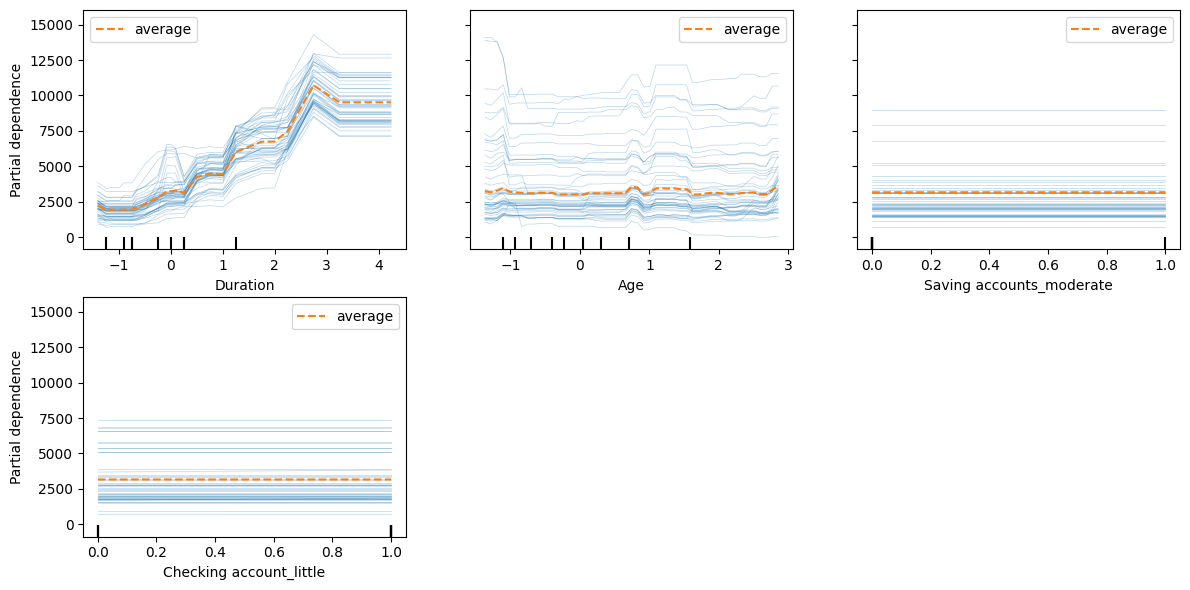

In [ ]:
features_to_plot = ['Duration', 'Age', 'Saving accounts_moderate', 'Checking account_little']


fig, ax = plt.subplots(figsize=(12, 6))
display = PartialDependenceDisplay.from_estimator(
    model,
    X_test,
    features=features_to_plot,
    kind='both',
    subsample=50,
    grid_resolution=50,
    ax=ax
)
plt.tight_layout()
plt.show()

## Comparing Aligned vs. Deviating Applicants

To better understand how individual behavior compares with global trends, This section identifies the five most **aligned** and five most **deviating** applicants based on their ICE curves for the `Duration` feature. Alignment is computed as the Euclidean distance between each applicant’s ICE curve and the global PDP for that feature.

The table below summarizes key standardized features for both groups, highlighting differences in characteristics such as loan duration, age, and account status.

Notably, both aligned and deviating applicants include individuals with low `Saving accounts_moderate` values (all zeros except for one aligned case), suggesting that this feature alone does not drive deviation. Aligned applicants tend to have shorter `Duration` values (mostly negative), while deviating applicants span a broader range, including a notably high duration of 2.25. `Age` is also more varied among deviating applicants, including outliers such as index 917 with a standardized age of 2.85, compared to the mostly younger aligned group. Nearly all deviating applicants have `Checking account_little` = 1.0, while the aligned group is more mixed. This suggests that deviation may be linked to unexpected model responses when low checking balances appear alongside atypical durations or older age.

In [ ]:
aligned_indices = summary_sorted.head(5).index.tolist()
deviating_indices = summary_sorted.tail(5).index.tolist()
all_indices = aligned_indices + deviating_indices

features_of_interest = ['Duration', 'Age', 'Saving accounts_moderate', 'Checking account_little']

selected_applicants = X_test.loc[all_indices, features_of_interest].copy()
selected_applicants['Type'] = ['Aligned'] * len(aligned_indices) + ['Deviating'] * len(deviating_indices)

selected_applicants

,Duration,Age,Saving accounts_moderate,Checking account_little,Type
351,-0.987573,-0.575737,0.0,0.0,Aligned
662,0.008048,1.271265,0.0,1.0,Aligned
319,-0.489762,-0.751642,0.0,1.0,Aligned
670,0.256953,-0.751642,1.0,1.0,Aligned
86,-0.240857,-0.751642,0.0,0.0,Aligned
995,-0.738668,-0.399832,0.0,1.0,Deviating
584,-0.738668,1.447170,0.0,1.0,Deviating
650,2.248194,1.271265,0.0,1.0,Deviating
292,0.256953,0.743550,0.0,1.0,Deviating
917,-1.236478,2.854409,0.0,1.0,Deviating


## Takeaways

By combining global and individual-level model interpretability, this pipeline shows how feature effects on loan amount predictions vary across applicants. ICE curves reveal how certain individuals diverge from general model behavior, and comparing aligned versus deviating applicants reveals how feature interactions shape loan sizing outcomes.

In the context of loan sizing, such insights are crucial. Financial institutions often rely on complex models to assign credit amounts, but without transparency, these models can inadvertently reach biased or unjust outcomes. This scenario demonstrated how PDP and ICE curves can surface variation and inconsistencies that may otherwise go unnoticed.

Ultimately, this pipeline supports more trustworthy AI in financial settings by providing accurate and explainable predictions that empower stakeholders to audit decisions, ensure fairness, and take corrective action when needed.